In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import seaborn as sns
import importlib
import utilis
import scipy
importlib.reload(utilis)
from scipy.io import mmread
import matplotlib.pyplot as plt
import magic
import scipy.stats as stats
import ptitprince as pt
import re
import os
from pathlib import Path
import anndata as ad
import gseapy as gp
import celltypist
import scrublet as scr

## Data Collection

In this anaylsis, we considered data from female breast cancer patients provided by [[Azizi et al., 2018]](https://pubmed.ncbi.nlm.nih.gov/29961579/). The dataset contains samples from 11 patients and is publically available in the GEO database under the GEO ID [GSE114727](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE114727). This dataset is ideal as we are intereseted in the gene expression differences between CD8$^+$ T cells in a tumor tissue and healthy tissue. We, however, considered only three patients, i.e. **BC01**, **BC02** and **BC03**, as both tumor and healthy samples from the same patient were taken only from these patients. 

The samples of each of the three patients are provided in separate files in a `.csv` format. Therefore, we first concatenate all cells and genes from all samples into one `.h5ad` file. As not all sample have the same gene set, genes that are not expressed in certain samples are assigned to zero in cells for which this gene was not captured.

## Qulaity Control

First, we construcct a .h5ad file containing tumor and healthy samples from the three breast cancer patients. The .h5ad  file conatins 35489 cells and 31487 genes.

In [ ]:
donor_ids = ['BC01', 'BC02', 'BC03']
tumor_normal_tissue = ['TUMOR', 'NORMAL']

In [ ]:
adatas = {}

In [ ]:
path = Path('../data/azizi_data/GSE114727_RAW-2/GSM3148.*_*_.*_counts.csv')
regex = re.compile(path.name)
print(path.parent)

In [ ]:
path = Path('../data/azizi_data/GSE114727_RAW-2/GSM3148.*_*_.*_counts.csv')
regex = re.compile(path.name)

for root, dirs, files in os.walk(path.parent):
    for file in files:
        print(file)
        if regex.fullmatch(file):
            print(file)

            patient_id = file[11:15]
            tissue = file[16:-11]

            df = pd.read_csv(f'{path.parent}/{file}')
            df = df.set_index('Unnamed: 0', drop = True)
            ccr_X = df.to_numpy()

            crr_var = pd.DataFrame([{'Gene' : gene} for gene in list(df.columns)])

            samples_size = df.shape[0]
            crr_obs = [{'Patient ID' : patient_id, 'Tissue' : tissue, 'Tumor' : tissue.startswith('TUMOR'), 'Normal' : tissue.startswith('NORMAL')}]*samples_size

            crr_adata = sc.AnnData(X = ccr_X, obs = crr_obs, var = crr_var)
            crr_adata.var_names = list(crr_var['Gene'])

            adatas[file] = crr_adata
            crr_adata.write(f'{path.parent}/{patient_id}_{tissue}.h5ad')

In [ ]:
concatenated_adata = ad.concat(adatas, label = 'dataset', join = 'outer')

In [ ]:
concatenated_adata.write('../data/azizi_data/concatenated_three_patients_original.h5ad')

In [2]:
adata = sc.read_h5ad('../data/azizi_data/concatenated_three_patients_original.h5ad')
adata

AnnData object with n_obs × n_vars = 35489 × 31487
    obs: 'Patient ID', 'Tissue', 'Tumor', 'Normal', 'dataset'

In [3]:
adata.obs['Condition'] = np.where(adata.obs['Normal'] == True, 'Normal', 'Tumor')

Now we apply some standard quality control steps to the gene expression matrix. First, as some genes were found to have nan (Not A Number) value, these values were set to zeros as some anaylsis ca not handle nan values.

In [4]:
adata.X = np.nan_to_num(adata.X, nan = 0)

In [5]:
# add the total counts per cell as observations-annotation to adata 
adata.obs['n_counts'] = adata.X.sum(axis = 1)

## Cell and Gene Filtering

Next, we filter out all cells that have expressed genes less than 200. Furthermore, we filter all genes that are expressed in less than 3 cells. As we are intereseted in all gene signature of the tumor and heathly cells, we will not filter cells that have high mitochondrial or ribosomal genes.

In [6]:
sc.pp.filter_cells(adata, min_genes = 200) 
sc.pp.filter_genes(adata, min_cells = 3)

In [7]:
print(f'Remaining cells {adata.shape[0]}.')
print(f'Remaining genes {adata.shape[1]}.')

Remaining cells 14669.
Remaining genes 24705.


In [8]:
adata.raw = adata

## Doublets Prediction & Removal

Next, we use the python package **Scrublet** in order to predict doublets cells using the raw count expression matrix.

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.74
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 10.4%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 0.8%
Elapsed time: 16.5 seconds
Number of predicted doublet is: 12


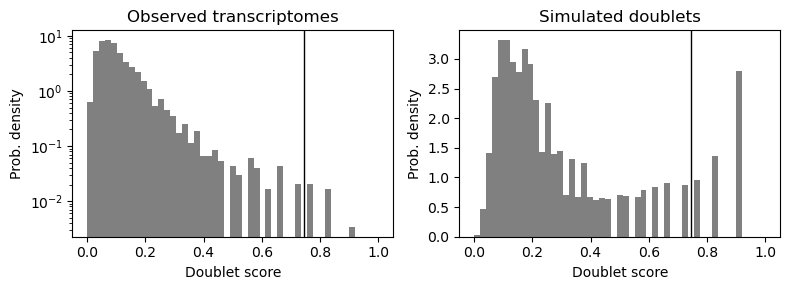

In [9]:
scrub = scr.Scrublet(adata.X)
adata.obs['doublet_scores'], adata.obs['predicted_doublets'] = scrub.scrub_doublets()
scrub.plot_histogram()
print(f'Number of predicted doublet is: {sum(adata.obs["predicted_doublets"])}')

The prediction indicates that there exist 12 doublet cells. We therefore filter out these cells.

In [10]:
# add in column with singlet/doublet instead of True/False 
adata.obs['doublet_info'] = adata.obs['predicted_doublets'].astype(str)

In [11]:
adata.obs['doublet_info'].value_counts()

False    14657
True        12
Name: doublet_info, dtype: int64

In [12]:
# also revert back to the raw counts as the main matrix in adata
#adata = adata.raw.to_adata() 

adata = adata[adata.obs['doublet_info'] == 'False', :]

print(f'Remaining cells {adata.shape[0]}.')
print(f'Remaining genes {adata.shape[1]}.')

Remaining cells 14657.
Remaining genes 24705.


## Save Quality Controled Data

Now we are done with the QC analysis. We save a new anndata file with the QC.

In [13]:
adata.write_h5ad('../data/azizi_data/concatenated_three_patients_quality_controled.h5ad')

... storing 'Condition' as categorical
... storing 'doublet_info' as categorical


## Dimentionality Reduction

Now we want to do dimentionality reduction analysis.

In [14]:
adata = sc.read_h5ad('../data/azizi_data/concatenated_three_patients_quality_controled.h5ad')
adata

AnnData object with n_obs × n_vars = 14657 × 24705
    obs: 'Patient ID', 'Tissue', 'Tumor', 'Normal', 'dataset', 'Condition', 'n_counts', 'n_genes', 'doublet_scores', 'predicted_doublets', 'doublet_info'
    var: 'n_cells'

As we sved the raw data from the previous step, we now need to normalize and logaritmize the data. Finally we save the normalized and logaritmized data into the raw slot.

In [15]:
# normalize to depth 10 000
sc.pp.normalize_per_cell(adata, counts_per_cell_after = 1e4)

# logaritmize
sc.pp.log1p(adata)

# store normalized counts in the raw slot, 
# we will subset adata.X for variable genes, but want to keep all genes matrix as well.
adata.raw = adata

Now we compute the highly variable genes and plot them. Finally we keep only the highly varuable genes in the data.

In [16]:
adata.X = np.nan_to_num(adata.X, nan = 0)

Highly variable genes: 5819


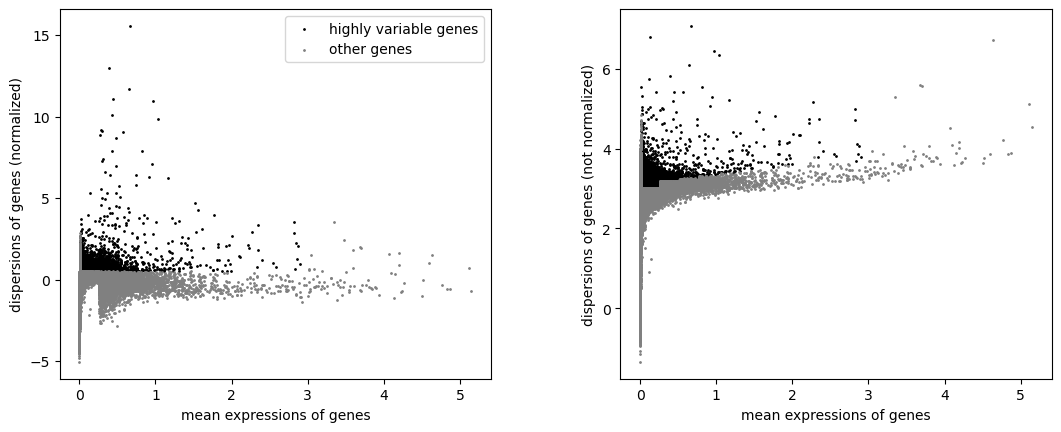

In [17]:
# compute variable genes
sc.pp.highly_variable_genes(adata, min_mean = 0.0125, max_mean = 3, min_disp = 0.5)
print(f'Highly variable genes: {sum(adata.var.highly_variable)}')

#plot variable genes
sc.pl.highly_variable_genes(adata)

# subset for variable genes in the dataset
adata = adata[:, adata.var['highly_variable']]

In [18]:
print(f'Remaining cells in raw data {adata.raw.shape[0]}.')
print(f'Remaining genes in raw data {adata.raw.shape[1]}.')

print(f'Remaining cells {adata.shape[0]}.')
print(f'Remaining genes {adata.shape[1]}.')

Remaining cells in raw data 14657.
Remaining genes in raw data 24705.
Remaining cells 14657.
Remaining genes 5819.


## Detect Highly Variable Genes From Each Batch

In [19]:
adata2 = adata.raw.to_adata() 

In [20]:
var_genes_all = adata.var.highly_variable

print("Highly variable genes: %d"%sum(var_genes_all))

Highly variable genes: 5819


In [21]:
sc.pp.highly_variable_genes(adata2, min_mean = 0.0125, max_mean = 3, min_disp = 0.5, batch_key = 'dataset')

print(f'Highly variable genes intersection: {sum(adata2.var.highly_variable_intersection)}')

print('Number of batches where gene is variable:')
print(adata2.var.highly_variable_nbatches.value_counts())

var_genes_batch = adata2.var.highly_variable_nbatches > 0

Highly variable genes intersection: 5
Number of batches where gene is variable:
0     5675
1     3609
2     2468
3     1987
4     1708
5     1534
6     1525
7     1359
8     1270
9     1105
10     895
11     621
12     411
13     262
14     142
15      60
16      36
17      14
18       8
19       7
21       5
20       4
Name: highly_variable_nbatches, dtype: int64


In [22]:
var_genes_all = adata.var.highly_variable

In [23]:
print(f'Any batch var genes: {sum(var_genes_batch)}')
print(f'All data var genes: {sum(var_genes_all)}')
print(f'Overlap: {sum(var_genes_batch & var_genes_all)}')
print(f'Variable genes in all batches: {sum(adata2.var.highly_variable_nbatches == 6)}')
print(f'Overlap batch instersection and all: {sum(var_genes_all & adata2.var.highly_variable_intersection)}')

Any batch var genes: 19030
All data var genes: 5819
Overlap: 5813
Variable genes in all batches: 1525
Overlap batch instersection and all: 5


Select all genes that are variable in at least 2 datasets and use for remaining analysis.

In [24]:
var_select = adata2.var.highly_variable_nbatches > 2
var_genes = var_select.index[var_select]
len(var_genes)

12953

## Data Integration Using Combat

We now integrate the data using Combat.

In [25]:
# create a new object with lognormalized counts
adata_combat = sc.AnnData(X = adata.raw.X, var = adata.raw.var, obs = adata.obs)

# first store the raw data 
adata_combat.raw = adata_combat

# run combat
sc.pp.combat(adata_combat, key = 'dataset')

In [26]:
adata_combat.X.shape

(14657, 24705)

In [27]:
adata_combat.X = np.nan_to_num(adata_combat.X, nan = 0)

Highly variable genes: 8074


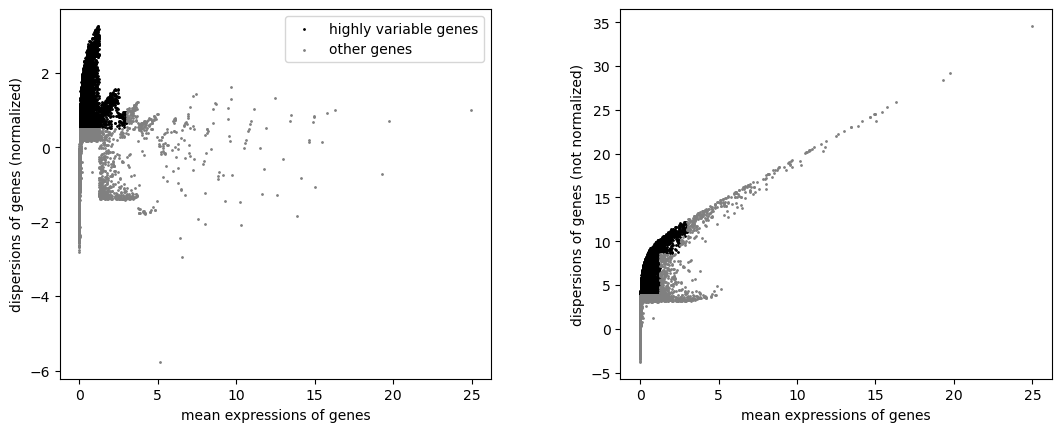

/opt/miniconda3/envs/leibniz/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [28]:
sc.pp.highly_variable_genes(adata_combat)
print(f'Highly variable genes: {sum(adata_combat.var.highly_variable)}')

sc.pl.highly_variable_genes(adata_combat)
sc.pp.pca(adata_combat, n_comps = 30, use_highly_variable = True, svd_solver = 'arpack')

sc.pp.neighbors(adata_combat, n_pcs = 25)

sc.tl.umap(adata_combat)
sc.tl.tsne(adata_combat, n_pcs = 25)

In [29]:
# compare var_genes
var_genes_combat = adata_combat.var.highly_variable
print(f'With all data {sum(var_genes_all)}')
print(f'With combat {sum(var_genes_combat)}')
print(f'Overlap {sum(var_genes_all & var_genes_combat)}')
print(f'With 2 batches {sum(var_select)}')
print(f'Overlap {sum(var_genes_combat & var_select)}')

With all data 5819
With combat 8074
Overlap 3058
With 2 batches 12953
Overlap 7209


In [ ]:
adata_combat.write_h5ad('../data/azizi_data/integrated_three_patients.h5ad')

## CD8+ T Cells Filtering

In [ ]:
adata = sc.read_h5ad('../data/azizi_data/integrated_three_patients.h5ad')
adata

In [ ]:
adata.obs['Patient ID'].value_counts()

In [ ]:
sc.pp.highly_variable_genes(adata)
sc.pp.pca(adata, n_comps = 30, use_highly_variable = True, svd_solver = 'arpack')
sc.pp.neighbors(adata, n_neighbors = 20)

In [ ]:
predictions_high = celltypist.annotate(adata, model = 'Immune_All_High.pkl', majority_voting = True, mode = 'best match')

In [ ]:
cell_types = {}
for cell_type in predictions_high.decision_matrix.columns:
    for i, cell in enumerate(predictions_high.decision_matrix.index):
        if predictions_high.decision_matrix.iloc[i][cell_type] >= 0:
            cell_types[cell] = cell_type

In [ ]:
adata.obs['Cell Type'] = [cell_types.get(i, 'unknown') for i in adata.obs.index]
adata.obs

In [ ]:
markers = {'T Cells' : ['TRBC2', 'CD3D', 'CD3G', 'CD3E', 'IL7R', 'GZMK', 'LTB', 'LEF1'], 'B Cells' : ['PXK', 'CD19', 'MS4A1', 'CD74', 'CD79A', 'IGHD'], 'NK Cells' : ['KLRD1', 'NKG7', 'GNLY', 'STYK1', 'GZMA', 'GZMB'], 'DC' : ['FCER1A', 'CST3', 'ZBTB46', 'ITGAX', 'CX3CR1', 'ITGAM'], 'Macrophages' : ['ID1', 'FAR2', 'IFITM1', 'NFIL3', 'NPL', 'OTUB2'], 'Monocytes' : ['LYZ', 'CFP', 'APOBEC3A', 'CD7', 'TET2'], 'NKT' : ['IL2RB', 'NCAM1', 'CD44', 'IL12RB2', 'CXCR4'], 'Plasma' : ['MZB1', 'SSR4', 'IGHG1']}
sc.pl.dotplot(adata, markers, groupby = 'Condition', show = False)
plt.savefig('../figures/marker_genes_all_cells.pdf', dpi = 300, bbox_inches = 'tight')
plt.savefig('../figures/marker_genes_all_cells.png', dpi = 300, bbox_inches = 'tight')

In [ ]:
t_cells = [p >= 0.6 for p in predictions_high.probability_matrix['T cells']]
print(f'Number of Predicted T Cells: {sum(t_cells)}')

In [ ]:
adata = adata[t_cells, :]
adata

In [ ]:
markers = {'T Cells' : ['TRBC2', 'CD3D', 'CD3G', 'CD3E', 'IL7R', 'GZMK', 'LTB', 'LEF1'], 'B Cells' : ['PXK', 'CD19', 'MS4A1', 'CD74', 'CD79A', 'IGHD'], 'NK Cells' : ['KLRD1', 'NKG7', 'GNLY', 'STYK1', 'GZMA', 'GZMB'], 'DC' : ['FCER1A', 'CST3', 'ZBTB46', 'ITGAX', 'CX3CR1', 'ITGAM'], 'Macrophages' : ['ID1', 'FAR2', 'IFITM1', 'NFIL3', 'NPL', 'OTUB2'], 'Monocytes' : ['LYZ', 'CFP', 'APOBEC3A', 'CD7', 'TET2'], 'NKT' : ['IL2RB', 'NCAM1', 'CD44', 'IL12RB2', 'CXCR4'], 'Plasma' : ['MZB1', 'SSR4', 'IGHG1']}
sc.pl.dotplot(adata, markers, groupby = 'Condition', dendrogram = True, show = False)

plt.savefig('../figures/marker_genes_T_cells.pdf', dpi = 300, bbox_inches = 'tight')
plt.savefig('../figures/marker_genes_T_cells.png', dpi = 300, bbox_inches = 'tight')

In [ ]:
# get index of CD8A & CD8B in the var list
cd8a_index = np.where(adata.var.index == 'CD8A')[0][0]
cd8b_index = np.where(adata.var.index == 'CD8B')[0][0]

df = pd.DataFrame({'CD8A' : adata.X[:, cd8a_index], 
                   'CD8B' : adata.X[:, cd8b_index]})

In [ ]:
sns.histplot(x = 'CD8A', data = df)
plt.yscale('log')
sns.despine()

In [ ]:
adata = adata[adata.X[:, ['CD8A' == var for var in adata.var_names]] > 2.5]
adata = adata[adata.X[:, ['CD8B' == var for var in adata.var_names]] > 2]

In [ ]:
adata.obs['Condition'].value_counts()

In [ ]:
markers = {'CD8+ T Cells' : ['CD8A', 'CD8B', 'TRBC2', 'CD3D', 'CD3G', 'CD3E', 'IL7R', 'GZMK', 'LTB', 'LEF1'], 'B Cells' : ['PXK', 'CD19', 'MS4A1', 'CD74', 'CD79A', 'IGHD'], 'NK Cells' : ['KLRD1', 'NKG7', 'GNLY', 'STYK1', 'GZMA', 'GZMB'], 'DC' : ['FCER1A', 'CST3', 'ZBTB46', 'ITGAX', 'CX3CR1', 'ITGAM'], 'Macrophages' : ['ID1', 'FAR2', 'IFITM1', 'NFIL3', 'NPL', 'OTUB2'], 'Monocytes' : ['LYZ', 'CFP', 'APOBEC3A', 'CD7', 'TET2'], 'NKT' : ['IL2RB', 'NCAM1', 'CD44', 'IL12RB2', 'CXCR4'], 'Plasma' : ['MZB1', 'SSR4', 'IGHG1']}
sc.pl.dotplot(adata, markers, groupby = 'Condition', dendrogram = True, show = False)

plt.savefig('../figures/marker_genes_CD8+_T_cells.pdf', dpi = 300, bbox_inches = 'tight')
plt.savefig('../figures/marker_genes_CD8+_T_cells.png', dpi = 300, bbox_inches = 'tight')

## Gene Set Activity Score - Module Score

In [ ]:
single_cell = pd.read_csv('../data/salt_data/DEG_high_vs_low_salt', sep = '\t')
single_cell.sort_values('avg_log2FC', inplace = True, ascending = False) 
single_cell.head()

In [ ]:
bulk = pd.read_csv('../data/salt_data/GA_AN0283_cd8_salt_diff_expression.csv')
bulk.sort_values('LFC_cd8_highsalt_vs_cd8_lowsalt', inplace = True, ascending = False) 
bulk.head()

In [ ]:
bulk_upregulated_sig = list(bulk.query('DE_cd8_highsalt_vs_cd8_lowsalt == "upregulated" and (FDR_cd8_highsalt_vs_cd8_lowsalt < 0.001)')['genename'])
bulk_downregulated_sig = list(bulk.query('DE_cd8_highsalt_vs_cd8_lowsalt == "downregulated" and (FDR_cd8_highsalt_vs_cd8_lowsalt < 0.001)')['genename'])

single_cell_upregulated_sig = list(single_cell.query('(avg_log2FC > 0) and (p_val_adj < 0.001)')['Unnamed: 0'])
single_cell_downregulated_sig = list(single_cell.query('(avg_log2FC < 0) and (p_val_adj < 0.001)')['Unnamed: 0'])


gene_set_significant = {'bulk_upregulated'         : bulk_upregulated_sig, 
                       'bulk_downregulated'        : bulk_downregulated_sig,
                       'single_cell_upregulated'   : single_cell_upregulated_sig,
                       'single_cell_downregulated' : single_cell_downregulated_sig}

In [ ]:
data_set = 'bulk_upregulated'
sc.tl.score_genes(adata, gene_set_significant[data_set])

Tumor_module = np.array(adata.obs[adata.obs.Condition=="Tumor"]["score"])
Normal_module = np.array(adata.obs[adata.obs.Condition=="Normal"]["score"])

plt.figure(figsize=(2, 2.5), dpi = 300)


sc.pl.umap(adata, color = ['score'], title = f'Module score of {data_set} in all CD45+ cells', show = False, color_map = 'Reds')
plt.savefig(f'../figures/CD45+_umap_module_score_of_{data_set}_genes_in_azizi_data.pdf', dpi = 300, bbox_inches = 'tight')
plt.clf()

plt.figure(figsize=(2, 2.5), dpi = 300)

alternative = "greater"
U1, p = stats.ranksums(Tumor_module, Normal_module, alternative = alternative)

colors = ['#ffa37b', '#A7C7E7']
customPalette = sns.set_palette(sns.color_palette(colors))

ax = sns.violinplot(data = [Tumor_module, Normal_module], saturation = 0.9, width = 0.9, palette = customPalette, linewidth = 0.3, kws = {'linecolor' : 'black'})
for i, c in enumerate(ax.collections):
    ax.collections[i].set_edgecolor('black')

sns.boxplot(data = [Tumor_module, Normal_module], width = 0.4,
            boxprops = {'zorder': 2, 'edgecolor' : 'black'},
            capprops = {'color' : 'black'},
            whiskerprops = {'color' : 'black'},
            medianprops = {'color' : 'black'},
            showfliers = False,
            linewidth = 0.3,
            ax = ax)

sns.stripplot(data = [Tumor_module, Normal_module], color = 'black', ax = ax, size = 0.4)

ax.set_ylabel(f'Transcriptom NaCl signature\n(Module score with {data_set})', fontsize=4)

ax.set_yticklabels(ax.get_yticks(), size=4);
ax.set_xticklabels(ax.get_xticklabels(), size=4);

labels = [item.get_text() for item in ax.get_yticklabels()]

ax.set_xticklabels(['Intratumoral tissue', 'Peritumoral tissue'])
ax.set_yticklabels([str(round(float(label), 2)) for label in labels])


ax.set_title(f'CD45+ cells\nWilcoxon rank sum test (alternative = {alternative})\n\np-value: {p}', fontsize=4)
sns.despine()

plt.savefig(f'../figures/CD45+_all_violin_plot_module_score_of_{data_set}_genes_in_Tumor_module_Mahima_list.png', dpi = 300, bbox_inches = 'tight')
plt.savefig(f'../figures/CD45+_all_violin_plot_module_score_of_{data_set}_genes_in_Tumor_module_Mahima_list.pdf', dpi = 300, bbox_inches = 'tight')

In [ ]:
data_set = 'single_cell_upregulated'
sc.tl.score_genes(adata, gene_set_significant[data_set])

Tumor_module = np.array(adata.obs[adata.obs.Condition=="Tumor"]["score"])
Normal_module = np.array(adata.obs[adata.obs.Condition=="Normal"]["score"])

plt.figure(figsize=(2, 2.5), dpi = 300)

alternative = "greater"
U1, p = stats.ranksums(Tumor_module, Normal_module, alternative = alternative)

colors = ['#ffa37b', '#A7C7E7']
customPalette = sns.set_palette(sns.color_palette(colors))

ax = sns.violinplot(data = [Tumor_module, Normal_module], saturation = 0.9, width = 0.9, palette = customPalette, linewidth = 0.3, kws = {'linecolor' : 'black'})
for i, c in enumerate(ax.collections):
    ax.collections[i].set_edgecolor('black')

sns.boxplot(data = [Tumor_module, Normal_module], width = 0.4,
            boxprops = {'zorder': 2, 'edgecolor' : 'black'},
            capprops = {'color' : 'black'},
            whiskerprops = {'color' : 'black'},
            medianprops = {'color' : 'black'},
            showfliers = False,
            linewidth = 0.3,
            ax = ax)

sns.stripplot(data = [Tumor_module, Normal_module], color = 'black', ax = ax, size = 0.4)

ax.set_ylabel(f'Transcriptom NaCl signature\n(Module score with {data_set})', fontsize=4)

ax.set_yticklabels(ax.get_yticks(), size=4);
ax.set_xticklabels(ax.get_xticklabels(), size=4);

labels = [item.get_text() for item in ax.get_yticklabels()]

ax.set_xticklabels(['Intratumoral tissue', 'Peritumoral tissue'])
ax.set_yticklabels([str(round(float(label), 2)) for label in labels])


ax.set_title(f'CD8+ T cells\n\np-value: {p}', fontsize=4)
sns.despine()

plt.savefig(f'../figures/CD8_all_violin_plot_module_score_of_{data_set}_genes_in_Tumor_module_Mahima_list.png', dpi = 300, bbox_inches = 'tight')
plt.savefig(f'../figures/CD8_all_violin_plot_module_score_of_{data_set}_genes_in_Tumor_module_Mahima_list.pdf', dpi = 300, bbox_inches = 'tight')